In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
df = pd.read_stata('hansen_dwi.dta')

        Date  Alcohol1  Alcohol2  low_score  male  white  recidivism  acc  \
0 2007-07-30         0         0        0.0   1.0    1.0         1.0  0.0   
1 2007-02-20         0         0        0.0   1.0    1.0         0.0  0.0   
2 2003-03-18         0         0        0.0   1.0    0.0         0.0  0.0   
3 2006-12-17         0         0        0.0   1.0    1.0         0.0  0.0   
4 1999-04-07         0         0        0.0   1.0    1.0         0.0  0.0   

   aged    year  bac1  bac2  dui  
0  48.0  2007.0   0.0   0.0    0  
1  51.0  2007.0   0.0   0.0    0  
2  68.0  2003.0   0.0   0.0    0  
3  51.0  2006.0   0.0   0.0    0  
4  22.0  1999.0   0.0   0.0    0  


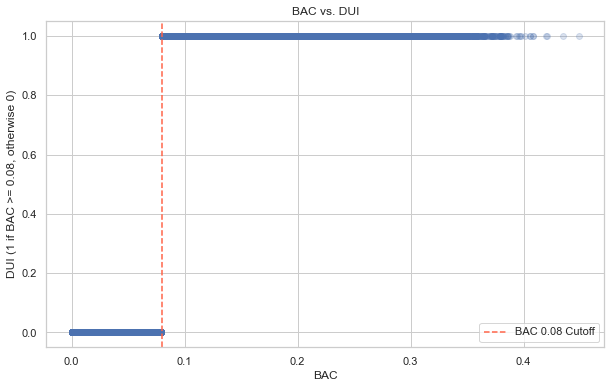

In [21]:
df['dui'] = (df['bac1'] >= 0.08).astype(int)
print(df.head())
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(df['bac1'], df['dui'], alpha=0.2)
plt.axvline(x=0.08, linestyle='--', color='tomato', label='BAC 0.08 Cutoff')
plt.xlabel('BAC')
plt.ylabel('DUI (1 if BAC >= 0.08, otherwise 0)')
plt.title('BAC vs. DUI')
plt.legend()
plt.show()

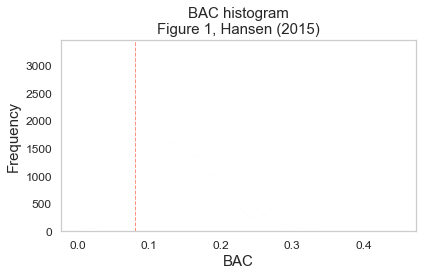

In [22]:
# Creating a histogram
plt.hist(df['bac1'], bins=np.arange(min(df['bac1']), max(df['bac1']) + 0.001, 0.001), color="#8aa1b4")

# Adding a vertical line at x = 0.08
plt.axvline(x=0.08, linewidth=1, linestyle='--', color='tomato', alpha=0.7)

# Setting labels and title
plt.xlabel('BAC', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('BAC histogram\nFigure 1, Hansen (2015)', fontsize=15)

# Customizing the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.grid(False)  # Turn off the grid, which is not present in the classic ggplot theme
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

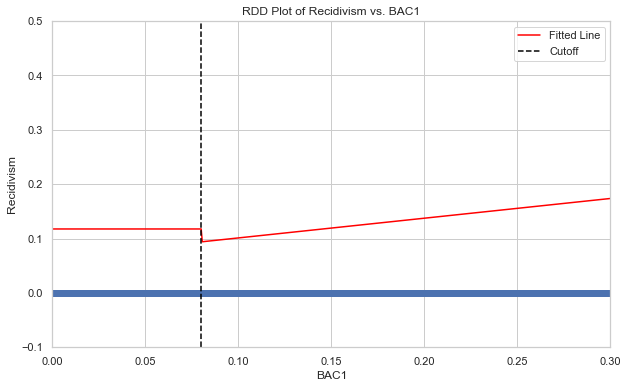

In [23]:
bw = 0.05
df['wt'] = np.where(np.abs(df['bac1'] - 0.08) <= bw, 1, 0)

# Filter the data to include only rows where 'wt' > 0
filtered_data = df[df['wt'] > 0]

# Define the regression formula
formula = 'recidivism ~ dui + bac1 + dui:bac1 + male + white + aged + acc'

# Fit the robust linear model with cluster-robust standard errors, using filtered data and weights
model = smf.wls(formula=formula, data=filtered_data, weights=filtered_data['wt']).fit(cov_type='cluster', cov_kwds={'groups': filtered_data['dui']})

# Set the style of the plot
sns.set_style("whitegrid")

# Define the cutoff and bandwidth
cutoff = 0.08

# Define the plot range and filter data for plotting
plot_range = (0, 0.3)
dwi_plot = df[(df['bac1'] >= plot_range[0]) & (df['bac1'] <= plot_range[1])]

# Plotting
plt.figure(figsize=(10, 6))
# Plot the scatter plot of the data points within the specified range
sns.scatterplot(x='bac1', y='recidivism', data=dwi_plot, alpha=0.5, edgecolor=None)

# Generating values for 'bac1' within the plot range for the fitted line
bac1_vals = np.linspace(plot_range[0], plot_range[1], 500)

# Predictions for the plot
predictions = model.get_prediction(pd.DataFrame({
    'bac1': bac1_vals,
    'dui': [1 if x >= cutoff else 0 for x in bac1_vals],
    'male': [np.mean(df['male'])] * len(bac1_vals),
    'white': [np.mean(df['white'])] * len(bac1_vals),
    'aged': [np.mean(df['aged'])] * len(bac1_vals),
    'acc': [np.mean(df['acc'])] * len(bac1_vals)
})).summary_frame(alpha=0.05)

# Plot the fitted regression lines
plt.plot(bac1_vals, predictions['mean'], color='red', label='Fitted Line')

# Drawing the cutoff line
plt.axvline(x=cutoff, linestyle='--', color='black', label='Cutoff')

# Setting plot labels and legend
plt.xlabel('BAC1')
plt.ylabel('Recidivism')
plt.title('RDD Plot of Recidivism vs. BAC1')
plt.legend()
plt.xlim(plot_range)
plt.ylim(-0.1, 0.5)  # Adjust y-axis limits to improve visibility if necessary
plt.show()

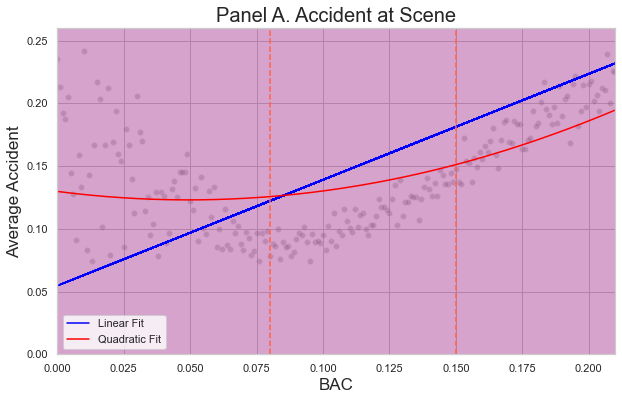

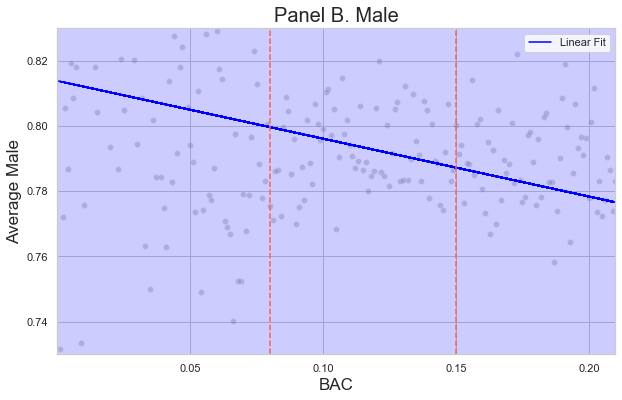

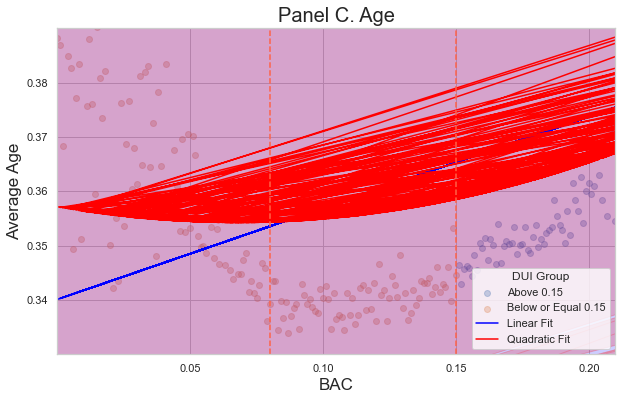

In [24]:
df['avg_acc'] = df.groupby('bac1')['acc'].transform('mean')
df.loc[df['bac1'] > 0.15, 'dui'] = 2

# Prepare data for linear fit
dwi_linear = df[['bac1', 'avg_acc']].drop_duplicates()

# OLS for linear fit
X_lin = sm.add_constant(dwi_linear['bac1'])
model_lin = sm.OLS(dwi_linear['avg_acc'], X_lin).fit()
prstd_lin, predict_mean_ci_low_lin, predict_mean_ci_upp_lin = wls_prediction_std(model_lin)

# Prepare data for quadratic fit
df['bac1_squared'] = df['bac1']**2
dwi_quadratic = df[['bac1', 'bac1_squared', 'avg_acc']].drop_duplicates().reset_index()

# OLS for quadratic fit
X_quad = sm.add_constant(dwi_quadratic[['bac1', 'bac1_squared']])
model_quad = sm.OLS(dwi_quadratic['avg_acc'], X_quad).fit()
prstd_quad, predict_mean_ci_low_quad, predict_mean_ci_upp_quad = wls_prediction_std(model_quad)

# Sorting for quadratic plot
sorted_order = np.argsort(dwi_quadratic['bac1'].values)
bac1_sorted = dwi_quadratic['bac1'].values[sorted_order]
fittedvalues_quad_sorted = model_quad.predict(X_quad).iloc[sorted_order]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Actual data points
ax.scatter(dwi_linear['bac1'], dwi_linear['avg_acc'], alpha=0.3, color='gray', edgecolor='white')

# Linear fit and confidence intervals
ax.plot(dwi_linear['bac1'], model_lin.predict(X_lin), color='blue', label='Linear Fit')
ax.fill_between(dwi_linear['bac1'], predict_mean_ci_low_lin, predict_mean_ci_upp_lin, color='blue', alpha=0.2)

# Quadratic fit and confidence intervals
ax.plot(bac1_sorted, fittedvalues_quad_sorted, color='red', label='Quadratic Fit')
ax.fill_between(bac1_sorted, predict_mean_ci_low_quad.iloc[sorted_order], predict_mean_ci_upp_quad.iloc[sorted_order], color='red', alpha=0.2)

# Vertical lines
ax.axvline(x=0.08, color='tomato', linestyle='--')
ax.axvline(x=0.15, color='tomato', linestyle='--')

# Customizing the plot
ax.set_xlim(0, 0.21)
ax.set_ylim(0, 0.26)
ax.set_xlabel('BAC', fontsize=17)
ax.set_ylabel('Average Accident', fontsize=17)
ax.set_title('Panel A. Accident at Scene', fontsize=20)
ax.legend()

plt.show()


# Pre-process the data for Panel B - Male
df['avg_male'] = df.groupby('bac1')['male'].transform('mean')
df.loc[df['bac1'] > 0.15, 'dui'] = 2

# Preparing data for linear fit
dwi_male = df[['bac1', 'avg_male']].drop_duplicates()

# OLS for linear fit
X_male_lin = sm.add_constant(dwi_male['bac1'])
model_male_lin = sm.OLS(dwi_male['avg_male'], X_male_lin).fit()
prstd_male_lin, predict_mean_ci_low_male_lin, predict_mean_ci_upp_male_lin = wls_prediction_std(model_male_lin)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for actual data points
ax.scatter(dwi_male['bac1'], dwi_male['avg_male'], alpha=0.3, color='gray', edgecolor='white')

# Linear model and CI
ax.plot(dwi_male['bac1'], model_male_lin.predict(X_male_lin), color='blue', label='Linear Fit')
ax.fill_between(dwi_male['bac1'], predict_mean_ci_low_male_lin, predict_mean_ci_upp_male_lin, color='blue', alpha=0.2)

# Vertical lines at BAC = 0.08 and BAC = 0.15
ax.axvline(x=0.08, color='tomato', linestyle='--')
ax.axvline(x=0.15, color='tomato', linestyle='--')

# Customizing the plot
ax.set_xlim(0, 0.21)
ax.set_ylim(0.73, 0.83)
ax.set_xlabel('BAC', fontsize=17)
ax.set_ylabel('Average Male', fontsize=17)
ax.set_title('Panel B. Male', fontsize=20)
ax.set_xticks([0.05, 0.1, 0.15, 0.2])
ax.set_yticks([0.74, 0.76, 0.78, 0.8, 0.82])
ax.legend()

plt.show()
#panel 3




# Pre-process the data for Panel C - Age
df['avg_age'] = df.groupby('bac1')['aged'].transform(lambda x: np.mean(x / 100))
df['dui_group'] = np.where(df['bac1'] > 0.15, 'Above 0.15', 'Below or Equal 0.15')

# Preparing data for linear fit
dwi_age = df[['bac1', 'avg_age', 'dui_group']].drop_duplicates()

# OLS for linear fit
X_age_lin = sm.add_constant(dwi_age['bac1'])
model_age_lin = sm.OLS(dwi_age['avg_age'], X_age_lin).fit()
prstd_age_lin, predict_mean_ci_low_age_lin, predict_mean_ci_upp_age_lin = wls_prediction_std(model_age_lin)

# Preparing data for quadratic fit
dwi_age['bac1_squared'] = dwi_age['bac1']**2
X_age_quad = sm.add_constant(dwi_age[['bac1', 'bac1_squared']])
model_age_quad = sm.OLS(dwi_age['avg_age'], X_age_quad).fit()
prstd_age_quad, predict_mean_ci_low_age_quad, predict_mean_ci_upp_age_quad = wls_prediction_std(model_age_quad)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for actual data points with different colors based on DUI group
for name, group in dwi_age.groupby('dui_group'):
    ax.scatter(group['bac1'], group['avg_age'], alpha=0.3, label=name)

# Linear and Quadratic models
ax.plot(dwi_age['bac1'], model_age_lin.predict(X_age_lin), color='blue', label='Linear Fit')
ax.fill_between(dwi_age['bac1'], predict_mean_ci_low_age_lin, predict_mean_ci_upp_age_lin, color='blue', alpha=0.2)

ax.plot(dwi_age['bac1'], model_age_quad.predict(X_age_quad), color='red', label='Quadratic Fit')
ax.fill_between(dwi_age['bac1'], predict_mean_ci_low_age_quad, predict_mean_ci_upp_age_quad, color='red', alpha=0.2)

# Vertical lines at BAC = 0.08 and BAC = 0.15
ax.axvline(x=0.08, color='tomato', linestyle='--')
ax.axvline(x=0.15, color='tomato', linestyle='--')

# Customize the plot
ax.set_xlim(0, 0.21)
ax.set_ylim(0.33, 0.39)
ax.set_xlabel('BAC', fontsize=17)
ax.set_ylabel('Average Age', fontsize=17)
ax.set_title('Panel C. Age', fontsize=20)
ax.set_xticks([0.05, 0.1, 0.15, 0.2])
ax.set_yticks([0.34, 0.35, 0.36, 0.37, 0.38])
ax.legend(title='DUI Group')

plt.show()

In [26]:
required_columns = ['bac1', 'recidivism', 'year', 'male', 'white', 'aged']  # 'dui' removed
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# Define the function to calculate rectangular kernel weights
def calculate_rectangular_weights(df, center, bandwidth):
    return np.where((df['bac1'] >= center - bandwidth) & (df['bac1'] <= center + bandwidth), 1, 0)

# Apply the function to calculate weights for 'dwi'
df['wt_3A'] = calculate_rectangular_weights(df, center=0.08, bandwidth=0.05)

# Filter the DataFrame to only include positive weights
dwi_filtered = df[df['wt_3A'] > 0]

# Ensure 'dwi_filtered' still contains all required columns after filtering
missing_columns_filtered = [col for col in required_columns if col not in dwi_filtered.columns]
if missing_columns_filtered:
    raise ValueError(f"Missing required columns after filtering: {missing_columns_filtered}")

# Adjust the formula to remove reference to the missing 'dui' column
formula = 'recidivism ~ bac1 + year + male + white + aged'

# Fit the model using WLS (Weighted Least Squares) with the calculated weights
model = smf.wls(formula, data=dwi_filtered, weights=dwi_filtered['wt_3A']).fit()

# Print the summary of the model
print(model.summary())


# Assuming 'dwi' DataFrame is already loaded with pd.read_stata or similar
# and contains the columns used in your model.

# Define function to calculate rectangular kernel weights
def calculate_rectangular_weights(df, center, bw):
    return np.where((df['bac1'] >= center - bw) & (df['bac1'] <= center + bw), 1, 0)

# Calculate weights and add them to the DataFrame
df['wt_3B'] = calculate_rectangular_weights(df, center=0.08, bw=0.025)

# Filter the DataFrame to only include positive weights
dwi_filtered = df[df['wt_3B'] > 0]

# Define the model using Patsy formula (similar to the R formula)
# Assuming 'recidivism', 'dui', 'bac1', 'year', 'male', 'white', and 'aged' are column names in your DataFrame.
formula = 'recidivism ~ dui + bac1 + dui * bac1 + year + male + white + aged'

# Fit the model using WLS (Weighted Least Squares) due to the presence of weights
model_3b1 = smf.wls(formula, data=dwi_filtered, weights=dwi_filtered['wt_3B']).fit()

# Print the summary of the model
print(model_3b1.summary())

                            WLS Regression Results                            
Dep. Variable:             recidivism   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     64.29
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           3.21e-67
Time:                        14:02:57   Log-Likelihood:                -21874.
No. Observations:               90074   AIC:                         4.376e+04
Df Residuals:                   90068   BIC:                         4.382e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5299      0.827      6.690      0.0